In [13]:
#GLOVE+Attention head LSTM classification
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention


def load_glove_model(glove_file):
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model


glove_file = '/content/drive/My Drive/RNNs_homofobia/vectors.txt'
glove_model = load_glove_model(glove_file)


def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower().strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)


xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)


y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_processed = [text.split() for text in xt['mesaj']]


max_len = 100  # Maksimum dizi uzunluğu
embedding_dim = 300  # GloVe vektör boyutu
embedding_matrix = np.zeros((len(glove_model) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(glove_model.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = glove_model[word]

def get_glove_sequences(texts):
    sequences = []
    for text in texts:
        sequence = [word_index[word] for word in text if word in word_index]
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_glove_sequences(X_processed)

# Modeli oluşturma fonksiyonu
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(LSTM(128, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_y_pred = []
all_y_test = []

for train_index, test_index in kfold.split(X_pad):
    model = create_model()
    model.fit(X_pad[train_index], y_encoded[train_index], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test_index], y_encoded[test_index], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test_index])
    y_pred_classes = np.argmax(y_pred, axis=1)
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test_index])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Confusion matrix ve classification report
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(all_y_test, all_y_pred, target_names=[str(cls) for cls in np.unique(y)])
print("\nClassification Report:")
print(class_report)

# Modeli eğit ve kaydet
model = create_model()
model.fit(X_pad, y_encoded, epochs=10, batch_size=32, verbose=1)
model.save('text_classification_model.h5')

# Modeli yükle
model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('LSTM+Glove Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = process_msg(message)
    message_seq = [word_index.get(word, 0) for word in message.split()]
    message_pad = pad_sequences([message_seq], maxlen=max_len)

    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(prediction_class)[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Cross-validation scores: [0.8391038775444031, 0.7744565010070801, 0.8308423757553101, 0.8383151888847351, 0.8430706262588501]
Mean cross-validation score: 0.8251577138900756
Confusion Matrix:
[[2868  841]
 [ 446 3206]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3709
           1       0.79      0.88      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.83      0.83      0.82      7361
weighted avg       0.83      0.83      0.82      7361



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6684 - loss: 0.5871
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8356 - loss: 0.3699
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8627 - loss: 0.3166
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8696 - loss: 0.2863
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8980 - loss: 0.2455
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9103 - loss: 0.2174
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9186 - loss: 0.1887
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9310 - loss: 0.1714
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9375 - loss: 0.1496
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9401 - loss: 0.1498


Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): merhaba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Tahmin: 1


KeyboardInterrupt: Interrupted by user

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Cross-validation scores: [0.8458927273750305, 0.826766312122345, 0.8308423757553101, 0.8396739363670349, 0.851222813129425]
Mean cross-validation score: 0.8388796329498291
Confusion Matrix:
[[3100  609]
 [ 577 3075]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3709
           1       0.83      0.84      0.84      3652

    accuracy                           0.84      7361
   macro avg       0.84      0.84      0.84      7361
weighted avg       0.84      0.84      0.84      7361



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6671 - loss: 0.5828
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8384 - loss: 0.3646
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8702 - loss: 0.2988
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8840 - loss: 0.2635
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8939 - loss: 0.2396
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9110 - loss: 0.2046
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9324 - loss: 0.1550
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9428 - loss: 0.1319
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9492 - loss: 0.1187
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9462 - loss: 0.1252


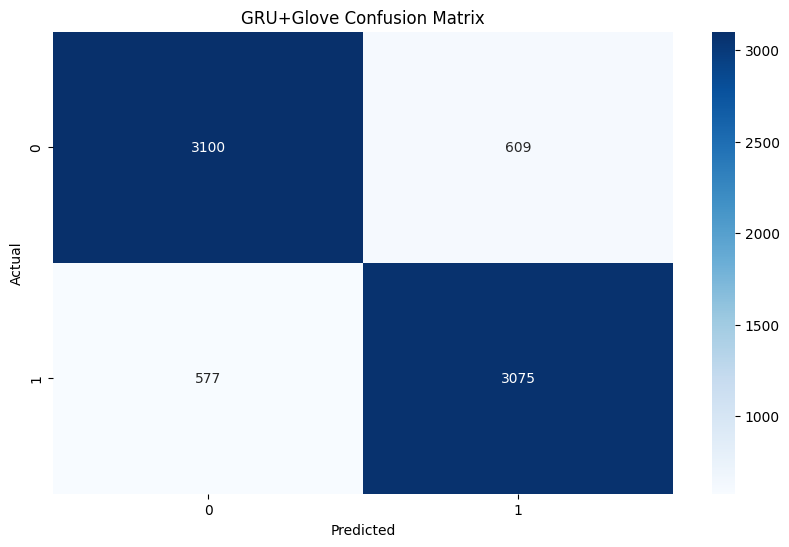

KeyboardInterrupt: Interrupted by user

In [18]:
#GLOVE+Attention head GRU classification
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention


def load_glove_model(glove_file):
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model


glove_file = '/content/drive/My Drive/RNNs_homofobia/vectors.txt'
glove_model = load_glove_model(glove_file)


def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower().strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)


xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)


y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_processed = [text.split() for text in xt['mesaj']]


max_len = 100  # Maksimum dizi uzunluğu
embedding_dim = 300  # GloVe vektör boyutu
embedding_matrix = np.zeros((len(glove_model) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(glove_model.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = glove_model[word]

def get_glove_sequences(texts):
    sequences = []
    for text in texts:
        sequence = [word_index[word] for word in text if word in word_index]
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_glove_sequences(X_processed)

# Modeli oluşturma fonksiyonu
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(GRU(64))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_y_pred = []
all_y_test = []

for train_index, test_index in kfold.split(X_pad):
    model = create_model()
    model.fit(X_pad[train_index], y_encoded[train_index], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test_index], y_encoded[test_index], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test_index])
    y_pred_classes = np.argmax(y_pred, axis=1)
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test_index])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")


conf_matrix = confusion_matrix(all_y_test, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(all_y_test, all_y_pred, target_names=[str(cls) for cls in np.unique(y)])
print("\nClassification Report:")
print(class_report)


model = create_model()
model.fit(X_pad, y_encoded, epochs=10, batch_size=32, verbose=1)
model.save('text_classification_model.h5')


model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('GRU+Glove Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = process_msg(message)
    message_seq = [word_index.get(word, 0) for word in message.split()]
    message_pad = pad_sequences([message_seq], maxlen=max_len)

    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(prediction_class)[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): aşk sana lazım bana değil
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Tahmin: 0
Başka bir sorunuz var mı? (evet/hayır): hayır
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Cross-validation scores: [0.821452796459198, 0.7880434989929199, 0.8491848111152649, 0.8322010636329651, 0.8301630616188049]
Mean cross-validation score: 0.8242090463638305
Confusion Matrix:
[[2834  875]
 [ 419 3233]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3709
           1       0.79      0.89      0.83      3652

    accuracy                           0.82      7361
   macro avg       0.83      0.82      0.82      7361
weighted avg       0.83      0.82      0.82      7361



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7065 - loss: 0.5630
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8415 - loss: 0.3578
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8566 - loss: 0.3188
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8838 - loss: 0.2733
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8993 - loss: 0.2288
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8940 - loss: 0.2370
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9307 - loss: 0.1614
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9055 - loss: 0.2196
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9474 - loss: 0.1296
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9554 - loss: 0.1054


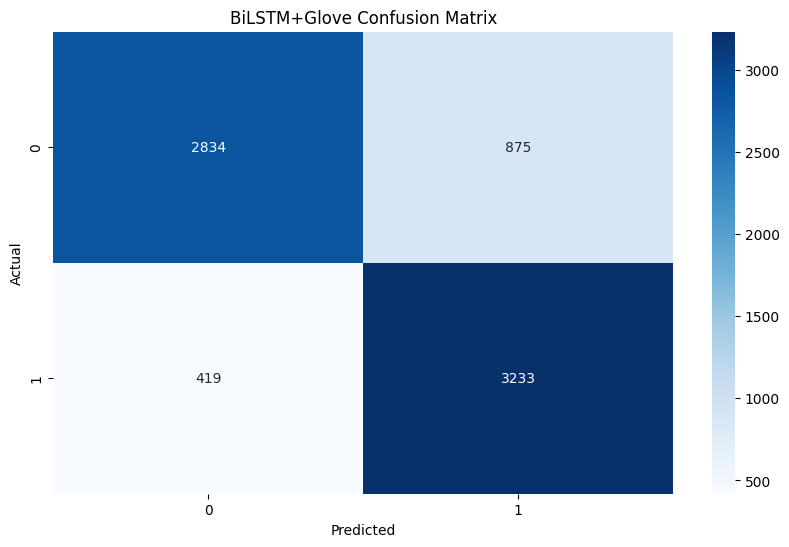

In [20]:
#GLOVE+Attention head BiLSTM classification
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
import seaborn as sns


def load_glove_model(glove_file):
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model


glove_file = '/content/drive/My Drive/RNNs_homofobia/vectors.txt'
glove_model = load_glove_model(glove_file)


def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower().strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)


xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)


y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_processed = [text.split() for text in xt['mesaj']]


max_len = 100  # Maksimum dizi uzunluğu
embedding_dim = 300  # GloVe vektör boyutu
embedding_matrix = np.zeros((len(glove_model) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(glove_model.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = glove_model[word]

def get_glove_sequences(texts):
    sequences = []
    for text in texts:
        sequence = [word_index[word] for word in text if word in word_index]
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_glove_sequences(X_processed)


def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_y_pred = []
all_y_test = []

for train_index, test_index in kfold.split(X_pad):
    model = create_model()
    model.fit(X_pad[train_index], y_encoded[train_index], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test_index], y_encoded[test_index], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test_index])
    y_pred_classes = np.argmax(y_pred, axis=1)
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test_index])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")


conf_matrix = confusion_matrix(all_y_test, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(all_y_test, all_y_pred, target_names=[str(cls) for cls in np.unique(y)])
print("\nClassification Report:")
print(class_report)


model = create_model()
model.fit(X_pad, y_encoded, epochs=10, batch_size=32, verbose=1)
model.save('text_classification_model.h5')


model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('BiLSTM+Glove Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [22]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = process_msg(message)
    message_seq = [word_index.get(word, 0) for word in message.split()]
    message_pad = pad_sequences([message_seq], maxlen=max_len)

    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(prediction_class)[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break

Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): pislik
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): şerefsiz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): allahın belası
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): seni seviyorum
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): evet
Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): merhaba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin: 1
Başka bir sorunuz var mı? (evet/hayır): hayır
Çıkış yapılıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Cross-validation scores: [0.836388349533081, 0.819972813129425, 0.84375, 0.8254076242446899, 0.829483687877655]
Mean cross-validation score: 0.8310004949569703
Confusion Matrix:
[[3053  656]
 [ 588 3064]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      3709
           1       0.82      0.84      0.83      3652

    accuracy                           0.83      7361
   macro avg       0.83      0.83      0.83      7361
weighted avg       0.83      0.83      0.83      7361



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6626 - loss: 0.6222
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8323 - loss: 0.3800
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8806 - loss: 0.2886
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9048 - loss: 0.2318
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9281 - loss: 0.1894
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9394 - loss: 0.1643
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9540 - loss: 0.1270
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9612 - loss: 0.1055
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.1028
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9653 - loss: 0.1008


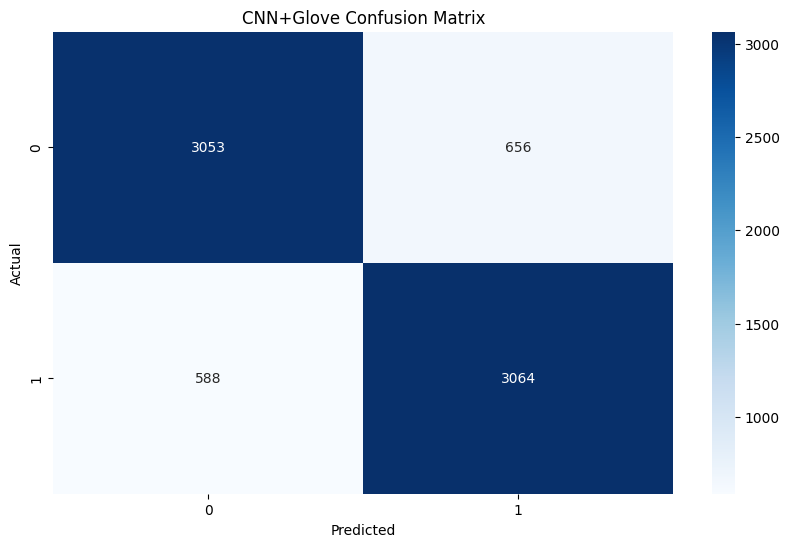

In [23]:
#GLOVE+Attention head CNN classification
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention
import seaborn as sns


def load_glove_model(glove_file):
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

# GloVe vektörlerini yükle
glove_file = '/content/drive/My Drive/RNNs_homofobia/vectors.txt'
glove_model = load_glove_model(glove_file)


def process_msg(text):
    text = re.sub(r'(@|https?)\S+|#', '', text)
    filters = '@!"\'#$%&()*+,-./:;<=>[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = text.lower().strip()
    stop_words = set(stopwords.words('turkish'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words_filtered)


xt = pd.read_excel('/content/drive/My Drive/TCK_hakaret_tespiti/half29072024_teknofest.xlsx')
xt = xt.dropna()
xt['mesaj'] = xt['mesaj'].astype(str).apply(process_msg)


y = xt['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_processed = [text.split() for text in xt['mesaj']]


max_len = 100  # Maksimum dizi uzunluğu
embedding_dim = 300  # GloVe vektör boyutu
embedding_matrix = np.zeros((len(glove_model) + 1, embedding_dim))
word_index = {word: i + 1 for i, word in enumerate(glove_model.keys())}
for word, i in word_index.items():
    embedding_matrix[i] = glove_model[word]

def get_glove_sequences(texts):
    sequences = []
    for text in texts:
        sequence = [word_index[word] for word in text if word in word_index]
        sequences.append(sequence)
    return pad_sequences(sequences, maxlen=max_len)

X_pad = get_glove_sequences(X_processed)


def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # Konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # Max pooling katmanı
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))  # İkinci konvolüsyon katmanı
    model.add(MaxPooling1D(pool_size=2))  # İkinci max pooling katmanı
    model.add(SeqSelfAttention(attention_activation='sigmoid'))  # Attention katmanı
    model.add(GlobalMaxPooling1D())  # Global max pooling katmanı
    model.add(Dropout(0.5))  # Dropout katmanı
    model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Çıkış katmanı
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
all_y_pred = []
all_y_test = []

for train_index, test_index in kfold.split(X_pad):
    model = create_model()
    model.fit(X_pad[train_index], y_encoded[train_index], epochs=10, batch_size=32, verbose=0)
    scores = model.evaluate(X_pad[test_index], y_encoded[test_index], verbose=0)
    cv_scores.append(scores[1])

    y_pred = model.predict(X_pad[test_index])
    y_pred_classes = np.argmax(y_pred, axis=1)
    all_y_pred.extend(y_pred_classes)
    all_y_test.extend(y_encoded[test_index])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")


conf_matrix = confusion_matrix(all_y_test, all_y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(all_y_test, all_y_pred, target_names=[str(cls) for cls in np.unique(y)])
print("\nClassification Report:")
print(class_report)


model = create_model()
model.fit(X_pad, y_encoded, epochs=10, batch_size=32, verbose=1)
model.save('text_classification_model.h5')


model = load_model('text_classification_model.h5', custom_objects={'SeqSelfAttention': SeqSelfAttention})

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('CNN+Glove Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# Test ekranı ve bitirme seçeneği
def classify_message(message):
    message = process_msg(message)
    message_seq = [word_index.get(word, 0) for word in message.split()]
    message_pad = pad_sequences([message_seq], maxlen=max_len)

    prediction = model.predict(message_pad)
    prediction_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(prediction_class)[0]

while True:
    message = input("Sınıflandırmak istediğiniz metni girin (çıkış için 'q' girin): ")
    if message.lower() == 'q':
        print("Test ekranından çıkılıyor...")
        break
    prediction = classify_message(message)
    print(f"Tahmin: {prediction}")

    another_question = input("Başka bir sorunuz var mı? (evet/hayır): ")
    if another_question.lower() != 'evet':
        print("Çıkış yapılıyor...")
        break